In [26]:
# import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [27]:
df = pd.read_csv('daily-min-temperatures.csv')
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [28]:
df.isna().sum()

Date    0
Temp    0
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [30]:
temp=df['Temp'].values
temp

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [31]:
temp = temp.reshape((len(temp), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(temp)
print('Min_Temp: %f, Max_Temp: %f' % (scaler.data_min_, scaler.data_max_))

temp_normalized = scaler.transform(temp)
temp_arr = np.array(temp_normalized)
temp = temp_arr.flatten()
temp

Min_Temp: 0.000000, Max_Temp: 26.300000


array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

Text(0.5, 1.0, 'Temperature average')

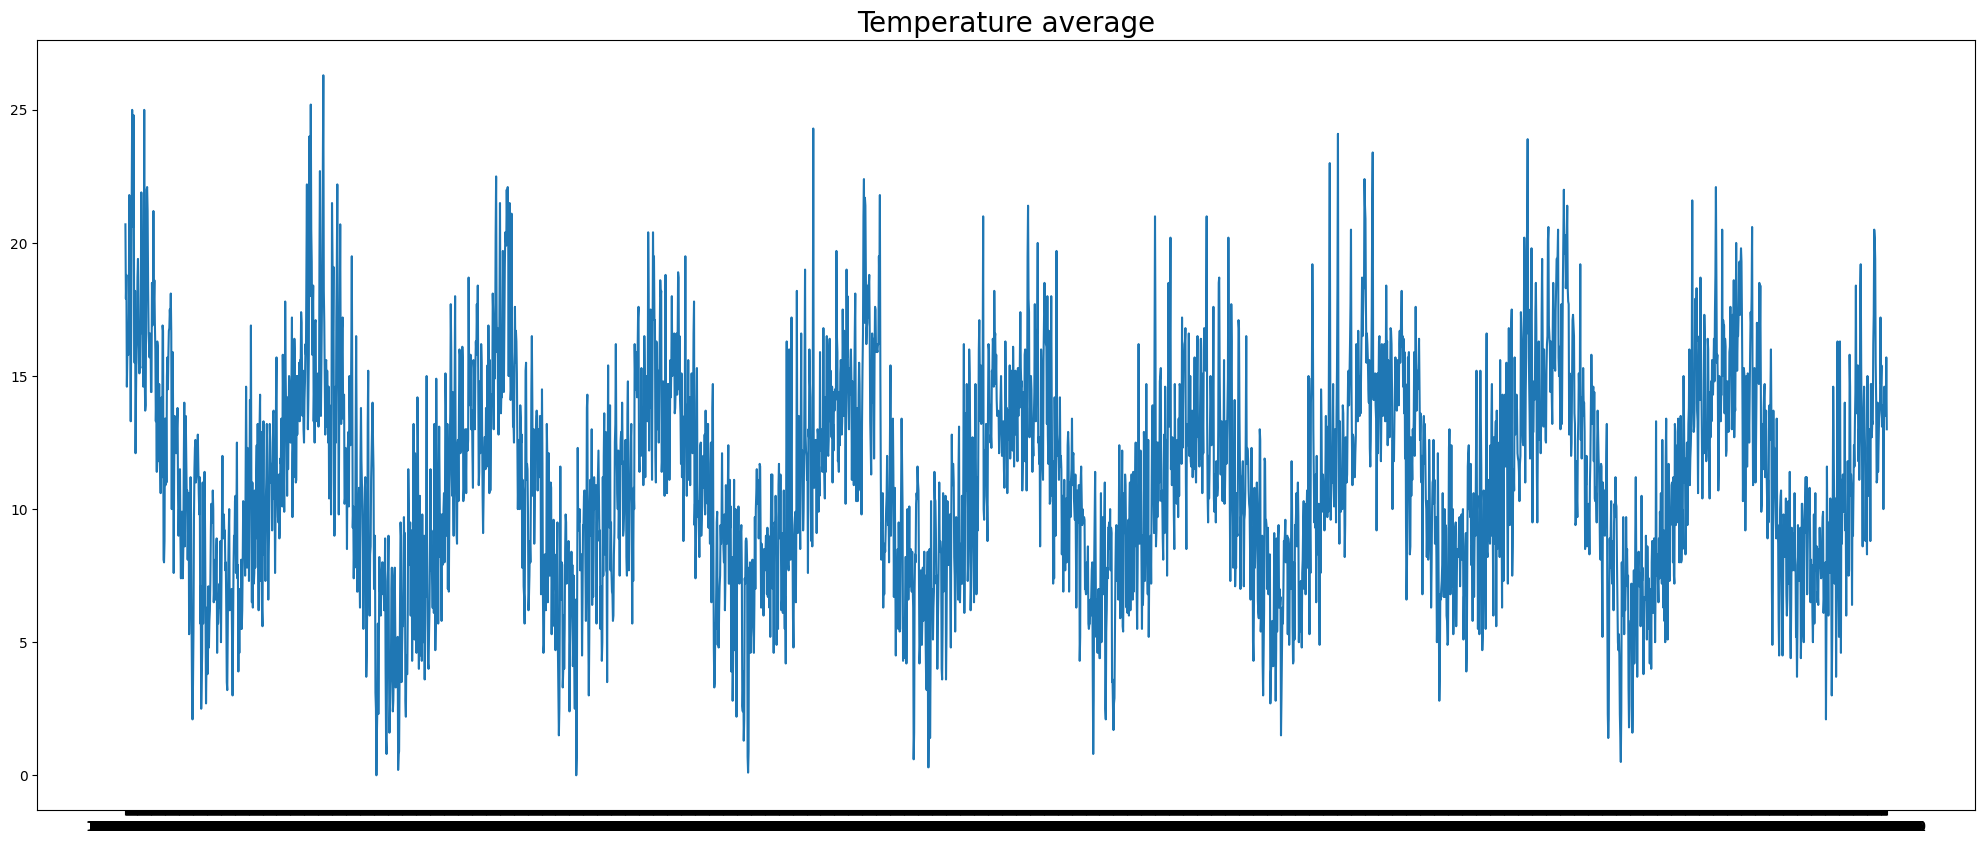

In [32]:
dates = df['Date'].values
Temp = df['Temp'].values

plt.figure(figsize=(25,10))
plt.plot(dates, Temp)
plt.title('Temperature average', fontsize=20)

In [33]:
maxmin_values = (df['Temp'].max() - df['Temp'].min())
maxmin_values

26.3

In [34]:
threshold_mae = maxmin_values * 10/100
threshold_mae

2.63

In [35]:
X_train, X_test, y_train, y_test = train_test_split(dates, temp, test_size=0.2, shuffle=False)

In [36]:
print('Jumlah data keseluruhan = ',df.shape)
print('Jumlah Train',y_train.shape)
print('Jumlah Test',y_test.shape)

Jumlah data keseluruhan =  (3650, 2)
Jumlah Train (2920,)
Jumlah Test (730,)


In [37]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [38]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(60)),
    Dense(68, activation="relu"),
    Dense(40, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [39]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae):
      print("\mae telah mencapai nilai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [40]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [41]:
history = model.fit(train_set, epochs=100, validation_data=val_set, verbose=1, callbacks=callbacks)

Epoch 1/100
     29/Unknown - 18s 323ms/step - loss: 0.0935 - mae: 0.4057\mae telah mencapai nilai <10%!
29/29 [==============================] - 21s 420ms/step - loss: 0.0935 - mae: 0.4057 - val_loss: 0.0898 - val_mae: 0.3963


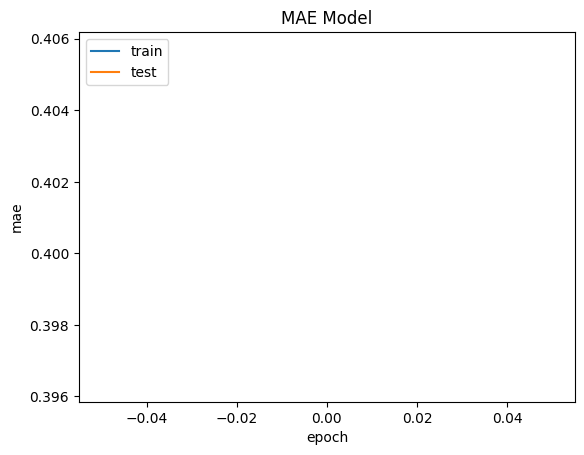

In [42]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

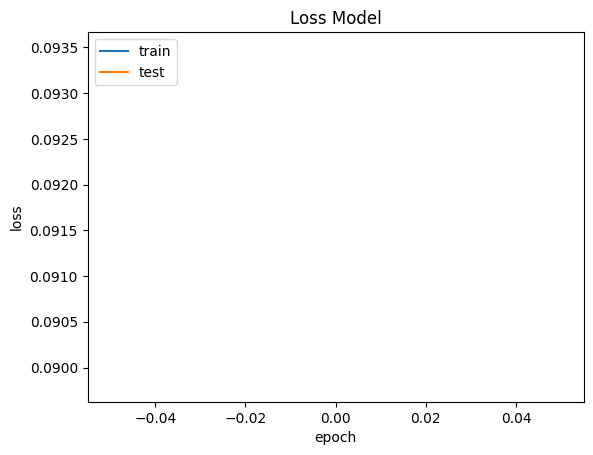

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
orgn_temp = df['Temp'].values

X_train, X_test, y_train, y_test = train_test_split(dates, orgn_temp, test_size=0.2, shuffle=False)

train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

history_orgn = model.fit(train_set, epochs=100, validation_data=val_set, verbose=1, callbacks=callbacks)

Epoch 1/100
29/29 [==============================] - 11s 374ms/step - loss: 10.3607 - mae: 10.8598 - val_loss: 10.3233 - val_mae: 10.8229
Epoch 2/100
29/29 [==============================] - 9s 300ms/step - loss: 10.0701 - mae: 10.5689 - val_loss: 9.9736 - val_mae: 10.4729
Epoch 3/100
29/29 [==============================] - 11s 372ms/step - loss: 9.7072 - mae: 10.2058 - val_loss: 9.5717 - val_mae: 10.0709
Epoch 4/100
29/29 [==============================] - 9s 300ms/step - loss: 9.2617 - mae: 9.7603 - val_loss: 9.0323 - val_mae: 9.5299
Epoch 5/100
29/29 [==============================] - 9s 289ms/step - loss: 8.6144 - mae: 9.1128 - val_loss: 8.2097 - val_mae: 8.7064
Epoch 6/100
29/29 [==============================] - 12s 392ms/step - loss: 7.5805 - mae: 8.0769 - val_loss: 6.8408 - val_mae: 7.3371
Epoch 7/100
29/29 [==============================] - 9s 308ms/step - loss: 5.8131 - mae: 6.3025 - val_loss: 4.5227 - val_mae: 5.0045
Epoch 8/100
29/29 [==============================] - 10s 

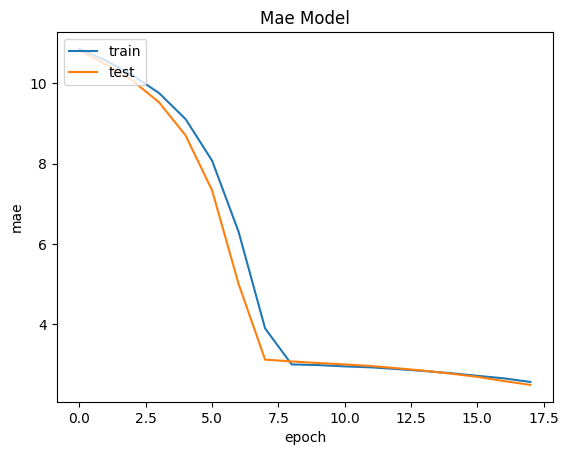

In [45]:
plt.plot(history_orgn.history['mae'])
plt.plot(history_orgn.history['val_mae'])
plt.title('Mae Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

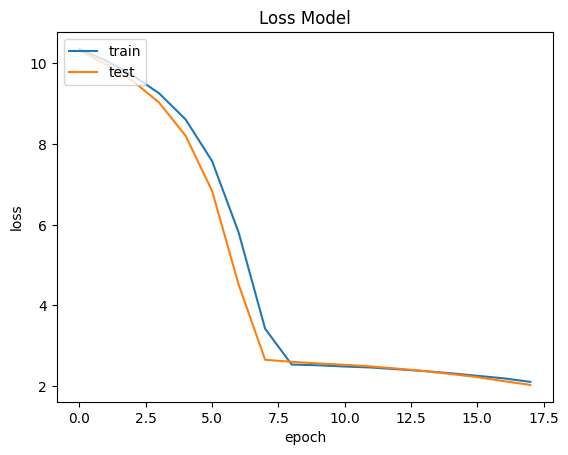

In [46]:
plt.plot(history_orgn.history['loss'])
plt.plot(history_orgn.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()